In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Black-Scholes formula for put option price
def black_scholes_put(S, K, T, r, sigma):
    if T <= 0:  # Gestione del caso di scadenza (T=0)
        return max(K - S, 0)  # Valore intrinseco a scadenza
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    put_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return put_price

In [3]:
# Function to calculate strike price for a given delta
def strike_from_delta(S, T, r, sigma, delta):
    if T <= 0:  # Gestione del caso di scadenza (T=0)
        return S  # A scadenza, lo strike per qualsiasi delta è il prezzo spot
    d1 = norm.ppf(delta) + sigma * np.sqrt(T)
    K = S * np.exp(-d1 * sigma * np.sqrt(T) + (r + 0.5 * sigma ** 2) * T)
    return K

In [4]:
# Calcolo del theta (derivata rispetto al tempo)
def black_scholes_theta_put(S, K, T, r, sigma):
    if T <= 0:  # Gestione del caso di scadenza (T=0)
        return 0  # Il theta a scadenza è 0
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    theta = -S * norm.pdf(d1) * sigma / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * norm.cdf(-d2)
    return theta / 365  # Theta giornaliero

In [5]:
# Parameters
S = 5600  # Current price of SP500
r = 0.01  # Risk-free interest rate
sigma = 0.22  # Volatility
days = 180  # Number of days to maturity

In [6]:
# Define a function to model the relationship between price changes and volatility
def adjusted_volatility(price_change_percent, base_volatility=sigma, sensitivity=1.5):
    """
    Calculate adjusted volatility based on price change.
    When price decreases, volatility increases more than proportionally.
    When price increases, volatility decreases more than proportionally.
    
    Args:
        price_change_percent: Percentage change in price (-20 means 20% decrease)
        base_volatility: Starting volatility level
        sensitivity: How sensitive volatility is to price changes
    """
    # More than proportional relationship with inverse correlation
    if price_change_percent < 0:
        # Price decrease -> volatility increase
        return base_volatility * (1 - (price_change_percent / 100) * sensitivity)
    else:
        # Price increase -> volatility decrease
        return max(0.05, base_volatility * (1 / (1 + (price_change_percent / 100) * sensitivity)))

In [7]:
# Time to maturity (in years) for the specified number of days, includendo la scadenza (T=0)
# Creating a non-linear distribution to better visualize the time decay effect
# More points close to expiration where theta changes more rapidly
T_values = np.concatenate([
    np.linspace(days/252, 30/252, 30),  # First 30 days, fewer points
    np.linspace(30/252, 7/252, 20),     # From 30 to 7 days
    np.linspace(7/252, 0, 16)           # Last 7 days, more points, including expiration
])
days_to_maturity = np.concatenate([
    np.linspace(days, 30, 30),
    np.linspace(30, 7, 20),
    np.linspace(7, 0, 16)               # Include exact expiration (0 days)
])

In [8]:
# Calculate put prices for different times to maturity
# Invece di usare uno strike fisso, calcola anche lo strike per il delta 50
K_delta_50 = [strike_from_delta(S, t, r, sigma, 1 - 0.5) for t in T_values]
put_prices = [black_scholes_put(S, k, t, r, sigma) for k, t in zip(K_delta_50, T_values)]

# Calculate strike price for delta 25
K_delta_25 = [strike_from_delta(S, t, r, sigma, 1 - 0.25) for t in T_values]
put_prices_delta_25 = [black_scholes_put(S, k, t, r, sigma) for k, t in zip(K_delta_25, T_values)]

# Calculate strike price for delta 75
K_delta_75 = [strike_from_delta(S, t, r, sigma, 1 - 0.75) for t in T_values]
put_prices_delta_75 = [black_scholes_put(S, k, t, r, sigma) for k, t in zip(K_delta_75, T_values)]

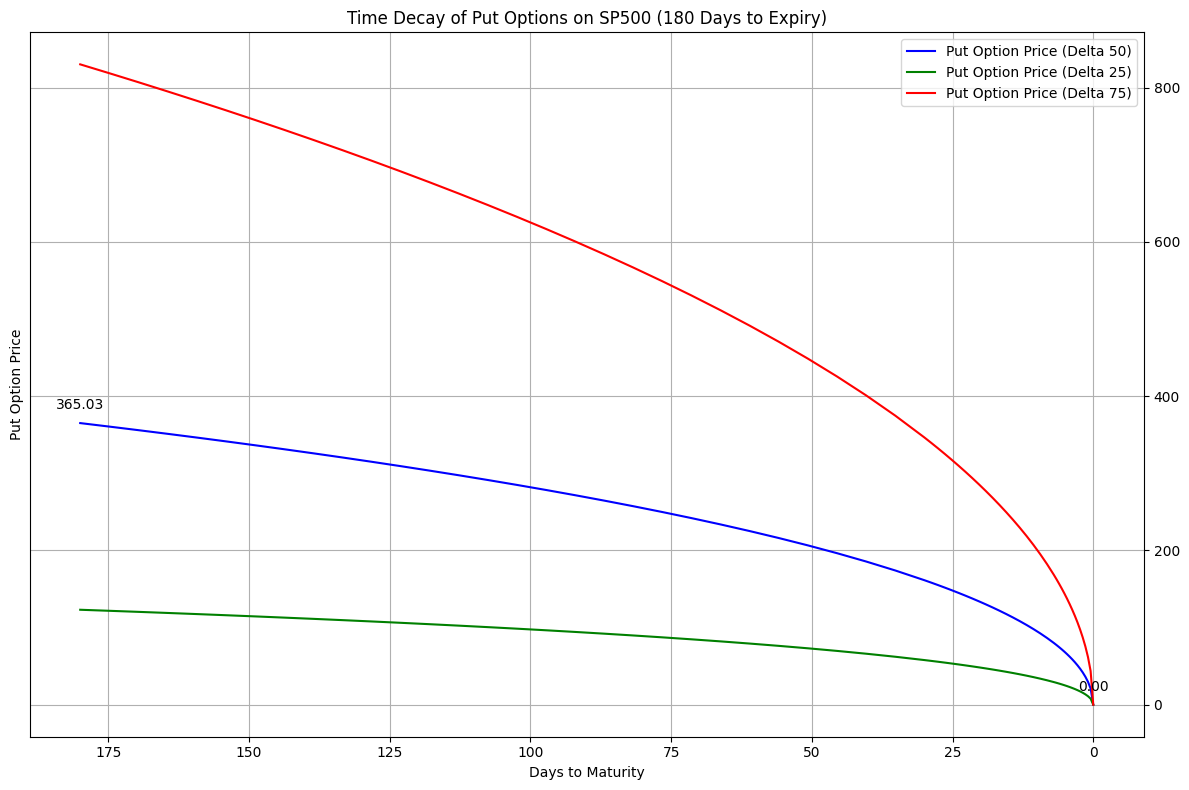

In [9]:
# Plotting the results
plt.figure(figsize=(12, 8))
plt.plot(days_to_maturity, put_prices, label='Put Option Price (Delta 50)', color='blue')
plt.plot(days_to_maturity, put_prices_delta_25, label='Put Option Price (Delta 25)', color='green')
plt.plot(days_to_maturity, put_prices_delta_75, label='Put Option Price (Delta 75)', color='red')

# Aggiungere annotazioni per i prezzi ad alcuni punti chiave
plt.annotate(f"{put_prices[0]:.2f}", (days_to_maturity[0], put_prices[0]), textcoords="offset points", 
             xytext=(0,10), ha='center')
plt.annotate(f"{put_prices[-1]:.2f}", (days_to_maturity[-1], put_prices[-1]), textcoords="offset points", 
             xytext=(0,10), ha='center')

plt.gca().invert_xaxis()  # Invert the x-axis
plt.gca().yaxis.tick_right()  # Move y-axis to the right
plt.xlabel('Days to Maturity')
plt.ylabel('Put Option Price')
plt.title('Time Decay of Put Options on SP500 (180 Days to Expiry)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

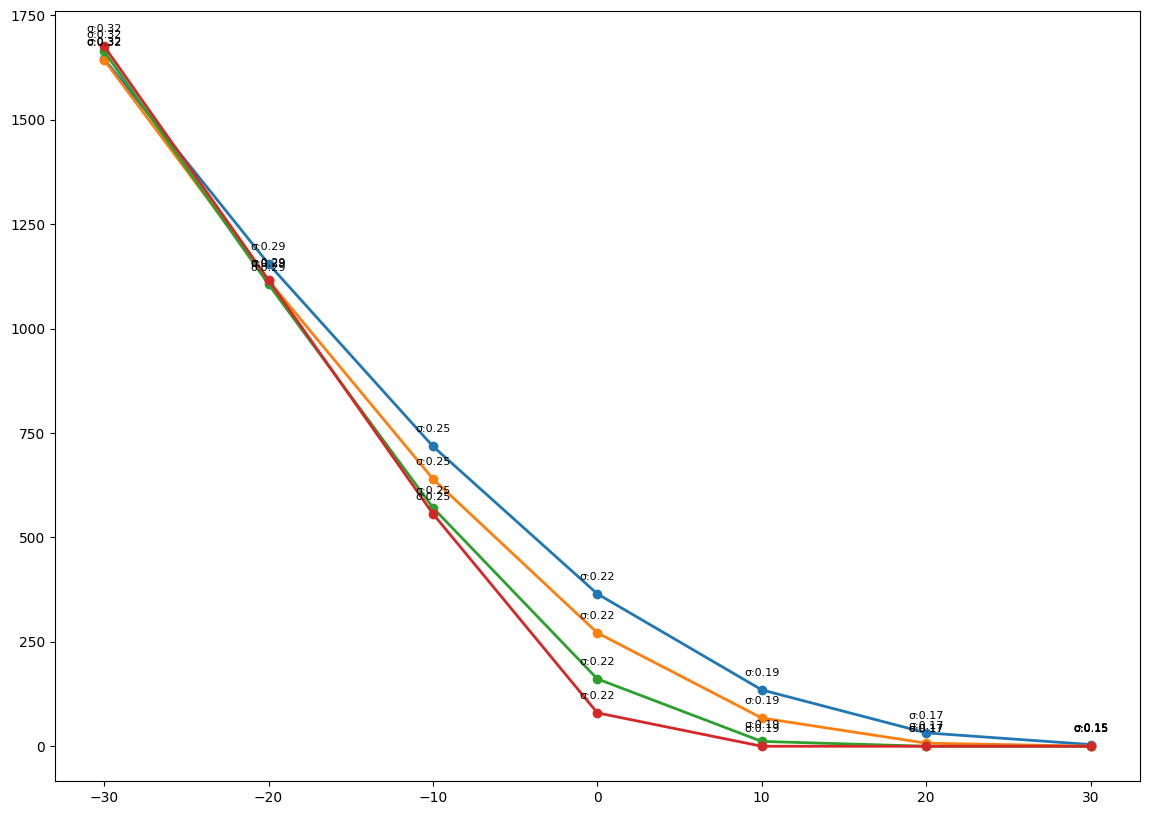

In [11]:
# Define scenarios: price changes from -30% to +30%
price_changes = np.array([-30, -20, -10, 0, 10, 20, 30])
reference_days = [180, 90, 30, 7]  # Selected days to maturity for analysis

# Create a new figure for the price change vs. option price analysis
plt.figure(figsize=(14, 10))

# For each selected time to maturity
for days_idx, days_to_exp in enumerate(reference_days):
    # Find the closest index in days_to_maturity array
    closest_idx = np.abs(days_to_maturity - days_to_exp).argmin()
    t_value = T_values[closest_idx]
    
    # Use the delta 50 strike for this time to maturity
    strike = K_delta_50[closest_idx]
    
    # Calculate option prices for different price changes and their corresponding volatilities
    adjusted_prices = []
    for pct_change in price_changes:
        # Calculate new price and adjusted volatility
        new_price = S * (1 + pct_change/100)
        new_vol = adjusted_volatility(pct_change)
        
        # Calculate option price with these parameters
        put_price = black_scholes_put(new_price, strike, t_value, r, new_vol)
        adjusted_prices.append(put_price)
    
    # Plot this time to maturity line
    plt.plot(price_changes, adjusted_prices, 
             marker='o', label=f'DTE: {int(days_to_exp)}', 
             linewidth=2)
    
    # Add annotations showing volatility at each point
    for i, pct_change in enumerate(price_changes):
        vol = adjusted_volatility(pct_change)
        plt.annotate(f"σ:{vol:.2f}", 
                    (price_changes[i], adjusted_prices[i]),
                    textcoords="offset points", 
                    xytext=(0, 10), 
                    ha='center',
                    fontsize=8)

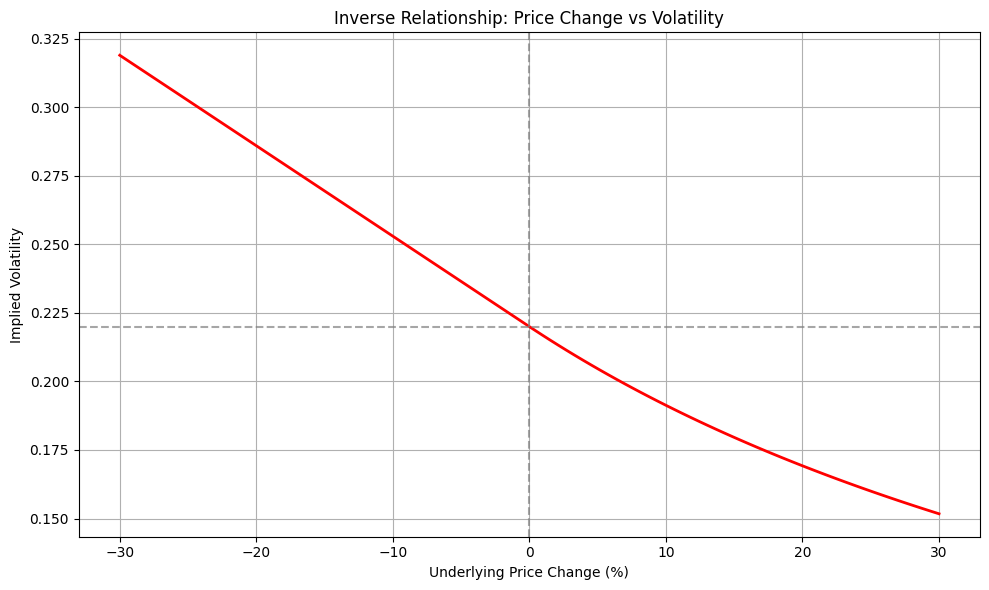

In [14]:
# Create a second figure showing the relationship between price change and volatility
plt.figure(figsize=(10, 6))
vol_changes = [adjusted_volatility(pc) for pc in np.linspace(-30, 30, 100)]
plt.plot(np.linspace(-30, 30, 100), vol_changes, 'r-', linewidth=2)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
plt.axhline(y=sigma, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Underlying Price Change (%)')
plt.ylabel('Implied Volatility')
plt.title('Inverse Relationship: Price Change vs Volatility')
plt.grid(True)
plt.tight_layout()
plt.show()

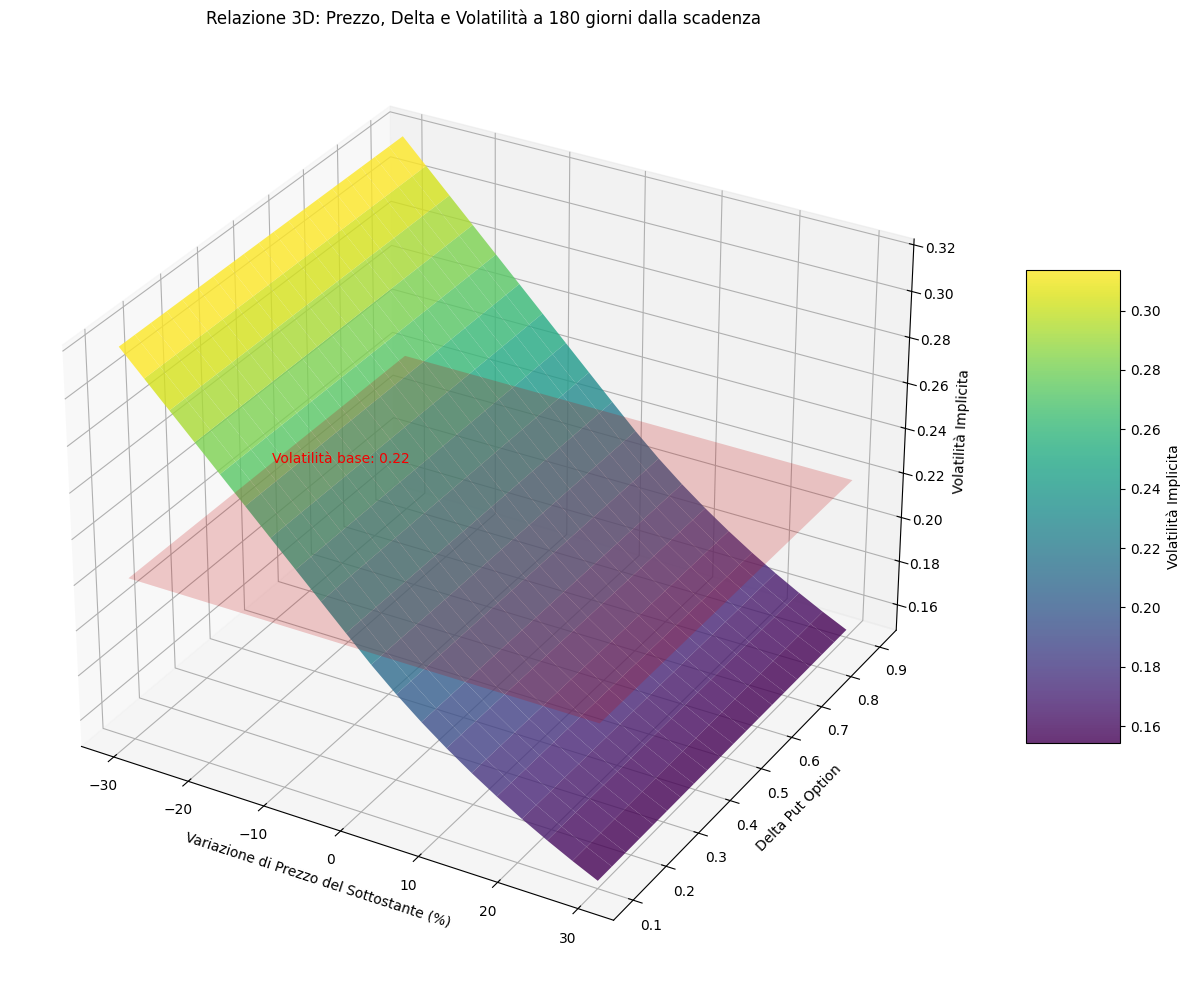

In [15]:
# Aggiungiamo un grafico 3D per visualizzare la relazione tra prezzo, volatilità e delta
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure to visualize price change, volatility and delta relationship
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Define range of price changes and delta values
price_changes_grid = np.linspace(-30, 30, 20)
delta_values = np.linspace(0.1, 0.9, 20)  # From 0.1 to 0.9 delta

# Create meshgrid for 3D surface
X, Y = np.meshgrid(price_changes_grid, delta_values)
Z = np.zeros_like(X)

# Choose a reference time to maturity (e.g., 30 days)
ref_dte = 180
closest_idx = np.abs(days_to_maturity - ref_dte).argmin()
t_value = T_values[closest_idx]

# Fill Z matrix with volatility values
for i, pc in enumerate(price_changes_grid):
    for j, delta_val in enumerate(delta_values):
        # Calculate volatility based on price change
        vol = adjusted_volatility(pc)
        
        # For each delta, calculate corresponding strike
        strike = strike_from_delta(S, t_value, r, vol, 1 - delta_val)
        
        # Store the volatility value
        Z[j, i] = vol

# Create the 3D surface plot
surf = ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8,
                      linewidth=0, antialiased=True)

# Add a color bar to show volatility values
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Volatilità Implicita')

# Set labels and title
ax.set_xlabel('Variazione di Prezzo del Sottostante (%)')
ax.set_ylabel('Delta Put Option')
ax.set_zlabel('Volatilità Implicita')
ax.set_title(f'Relazione 3D: Prezzo, Delta e Volatilità a {ref_dte} giorni dalla scadenza')

# Add reference plane at current volatility
xx, yy = np.meshgrid(np.linspace(-30, 30, 2), np.linspace(0.1, 0.9, 2))
zz = np.ones_like(xx) * sigma
ax.plot_surface(xx, yy, zz, color='red', alpha=0.2)
ax.text(-30, 0.5, sigma, f'Volatilità base: {sigma}', color='red')

plt.tight_layout()
plt.show()

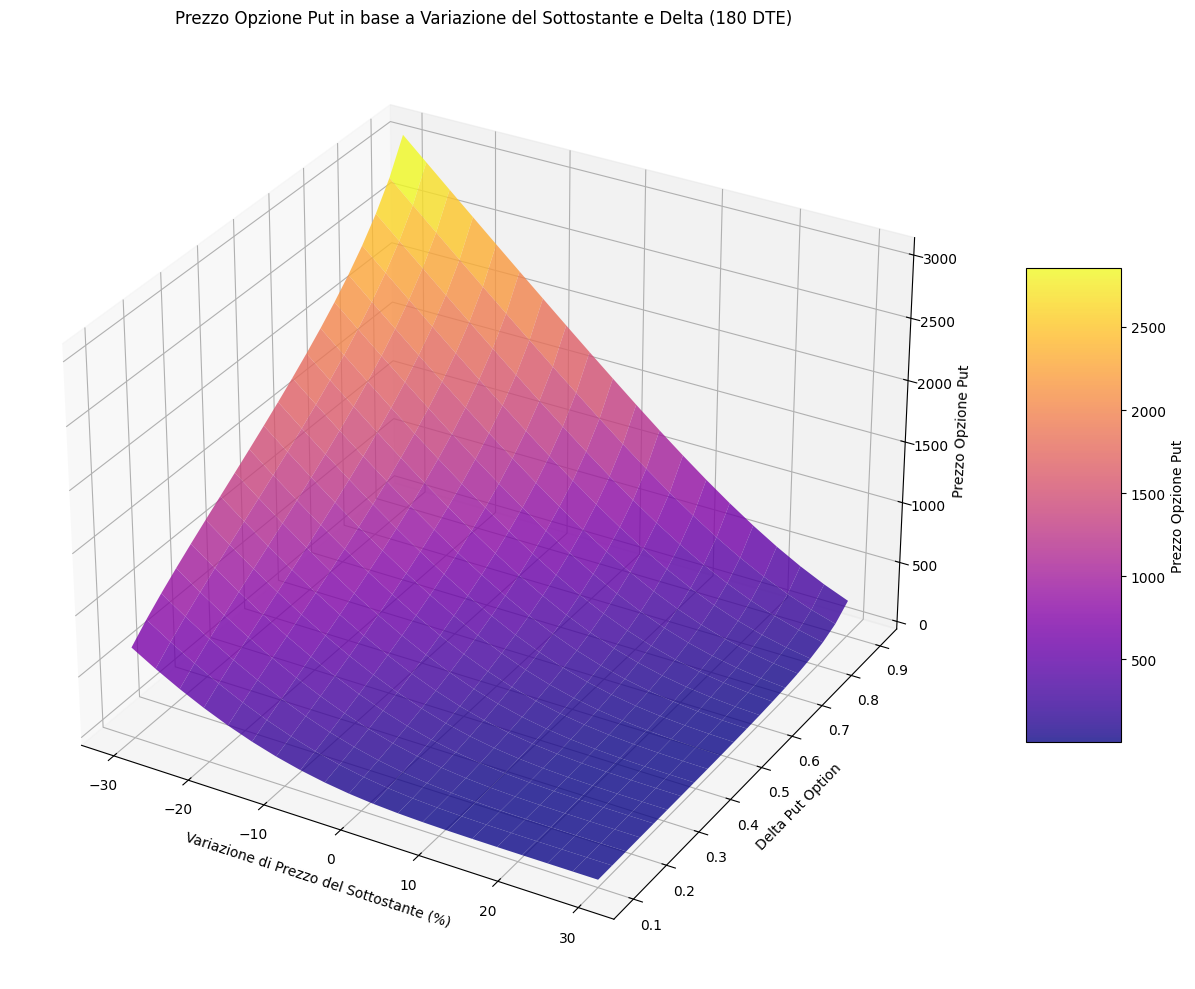

In [16]:
# Creiamo un'altra visualizzazione 3D per mostrare come cambia il prezzo dell'opzione
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Matrice per i prezzi delle opzioni
option_prices = np.zeros_like(X)

# Fill option_prices matrix
for i, pc in enumerate(price_changes_grid):
    for j, delta_val in enumerate(delta_values):
        # Calculate new price of underlying
        new_price = S * (1 + pc/100)
        
        # Calculate adjusted volatility based on price change
        vol = adjusted_volatility(pc)
        
        # Calculate strike for this delta
        strike = strike_from_delta(S, t_value, r, sigma, 1 - delta_val)
        
        # Calculate option price
        put_price = black_scholes_put(new_price, strike, t_value, r, vol)
        option_prices[j, i] = put_price

# Create the option price surface plot
surf = ax.plot_surface(X, Y, option_prices, cmap='plasma', alpha=0.8,
                      linewidth=0, antialiased=True)

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Prezzo Opzione Put')

# Set labels and title
ax.set_xlabel('Variazione di Prezzo del Sottostante (%)')
ax.set_ylabel('Delta Put Option')
ax.set_zlabel('Prezzo Opzione Put')
ax.set_title(f'Prezzo Opzione Put in base a Variazione del Sottostante e Delta ({ref_dte} DTE)')

plt.tight_layout()
plt.show()

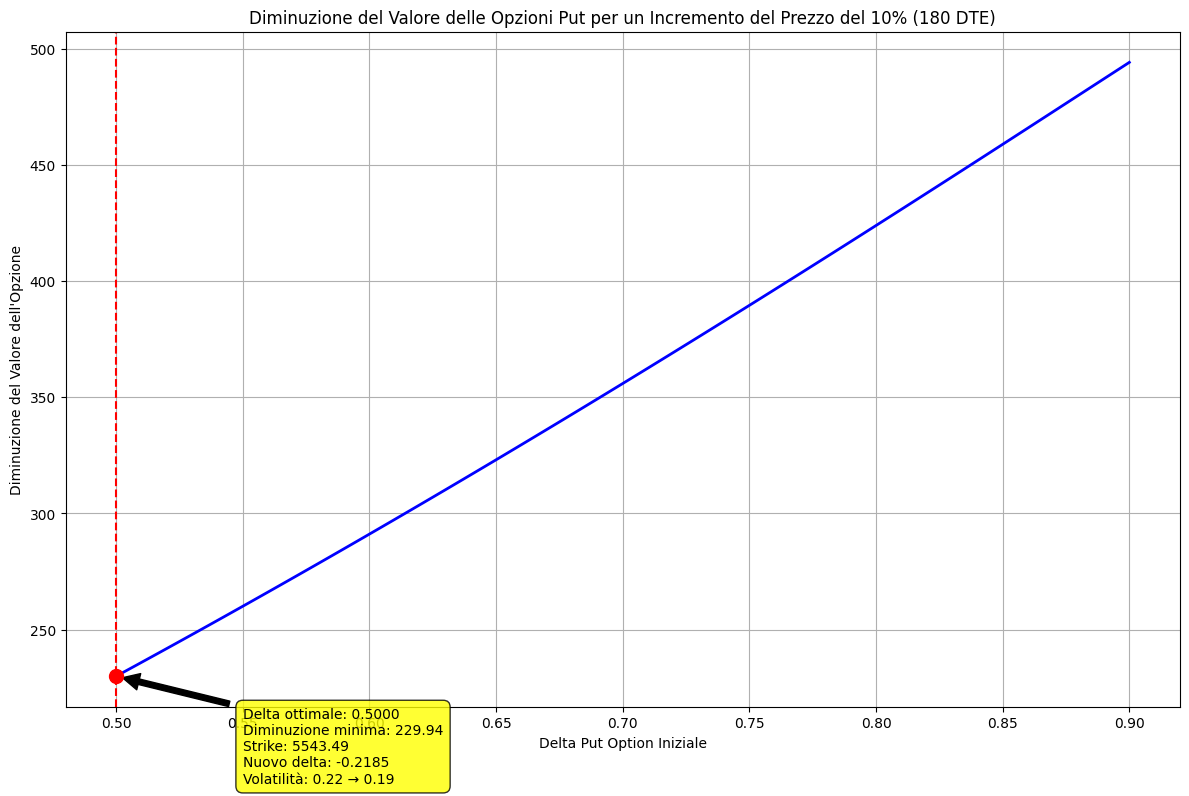

In [17]:
# Aggiungiamo un'analisi per trovare il delta ottimale con incremento del 10% del sottostante
plt.figure(figsize=(12, 8))

# Definiamo un range di delta più dettagliato per l'analisi
detailed_delta_values = np.linspace(0.5, 0.9, 100)  # Delta > 50 per opzioni put

# Modifichiamo il parametro per usare 180 giorni alla scadenza
ref_dte = 180  # 180 giorni alla scadenza invece di 30
closest_idx = np.abs(days_to_maturity - ref_dte).argmin()
t_value = T_values[closest_idx]

# Variazione percentuale prezzo del sottostante
price_change_pct = 10

# Calcolo del nuovo prezzo del sottostante (+10%)
new_price = S * (1 + price_change_pct/100)

# Calcolo della nuova volatilità (ridotta per aumento del prezzo)
new_vol = adjusted_volatility(price_change_pct)

# Vettori per i risultati
strike_prices = []
initial_put_prices = []
new_put_prices = []
price_changes = []
put_deltas = []

# Per ogni delta, calcola il cambiamento nel prezzo dell'opzione
for delta_val in detailed_delta_values:
    # Strike per questo delta con volatilità originale
    strike = strike_from_delta(S, t_value, r, sigma, 1 - delta_val)
    
    # Prezzo iniziale dell'opzione
    initial_put_price = black_scholes_put(S, strike, t_value, r, sigma)
    
    # Prezzo dell'opzione dopo la variazione
    new_put_price = black_scholes_put(new_price, strike, t_value, r, new_vol)
    
    # Delta dell'opzione nel nuovo scenario
    d1 = (np.log(new_price / strike) + (r + 0.5 * new_vol ** 2) * t_value) / (new_vol * np.sqrt(t_value))
    put_delta = -norm.cdf(-d1)
    
    # Salva i risultati
    strike_prices.append(strike)
    initial_put_prices.append(initial_put_price)
    new_put_prices.append(new_put_price)
    price_changes.append(initial_put_price - new_put_price)
    put_deltas.append(put_delta)

# Trova l'indice del delta con la minima diminuzione del valore dell'opzione
min_decrease_index = np.argmin(price_changes)
optimal_delta = detailed_delta_values[min_decrease_index]
min_decrease = price_changes[min_decrease_index]
optimal_strike = strike_prices[min_decrease_index]
new_optimal_delta = put_deltas[min_decrease_index]

# Visualizza i risultati
plt.plot(detailed_delta_values, price_changes, 'b-', linewidth=2)
plt.axvline(x=optimal_delta, color='red', linestyle='--')
plt.scatter(optimal_delta, min_decrease, color='red', s=100, zorder=5)

plt.grid(True)
plt.xlabel('Delta Put Option Iniziale')
plt.ylabel('Diminuzione del Valore dell\'Opzione')
plt.title(f'Diminuzione del Valore delle Opzioni Put per un Incremento del Prezzo del 10% ({ref_dte} DTE)')

# Annotazione dei risultati
plt.annotate(f'Delta ottimale: {optimal_delta:.4f}\n'
             f'Diminuzione minima: {min_decrease:.2f}\n'
             f'Strike: {optimal_strike:.2f}\n'
             f'Nuovo delta: {new_optimal_delta:.4f}\n'
             f'Volatilità: {sigma:.2f} → {new_vol:.2f}',
             xy=(optimal_delta, min_decrease),
             xytext=(optimal_delta + 0.05, min_decrease * 0.8),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))

plt.tight_layout()
plt.show()

In [18]:
# Stampa un riepilogo dei risultati
print(f"\nRisultati dettagliati per incremento del prezzo del {price_change_pct}% a {ref_dte} DTE:")
print(f"Delta ottimale iniziale: {optimal_delta:.4f}")
print(f"Strike price corrispondente: {optimal_strike:.2f}")
print(f"Prezzo iniziale dell'opzione: {initial_put_prices[min_decrease_index]:.2f}")
print(f"Nuovo prezzo dell'opzione: {new_put_prices[min_decrease_index]:.2f}")
print(f"Diminuzione minima del valore: {min_decrease:.2f} ({min_decrease/initial_put_prices[min_decrease_index]*100:.2f}%)")
print(f"Variazione della volatilità: {sigma:.2f} → {new_vol:.2f}")
print(f"Nuovo delta dell'opzione: {new_optimal_delta:.4f}")
print(f"Prezzo sottostante: {S:.2f} → {new_price:.2f}")


Risultati dettagliati per incremento del prezzo del 10% a 180 DTE:
Delta ottimale iniziale: 0.5000
Strike price corrispondente: 5543.49
Prezzo iniziale dell'opzione: 365.03
Nuovo prezzo dell'opzione: 135.08
Diminuzione minima del valore: 229.94 (62.99%)
Variazione della volatilità: 0.22 → 0.19
Nuovo delta dell'opzione: -0.2185
Prezzo sottostante: 5600.00 → 6160.00


<Figure size 1200x800 with 0 Axes>

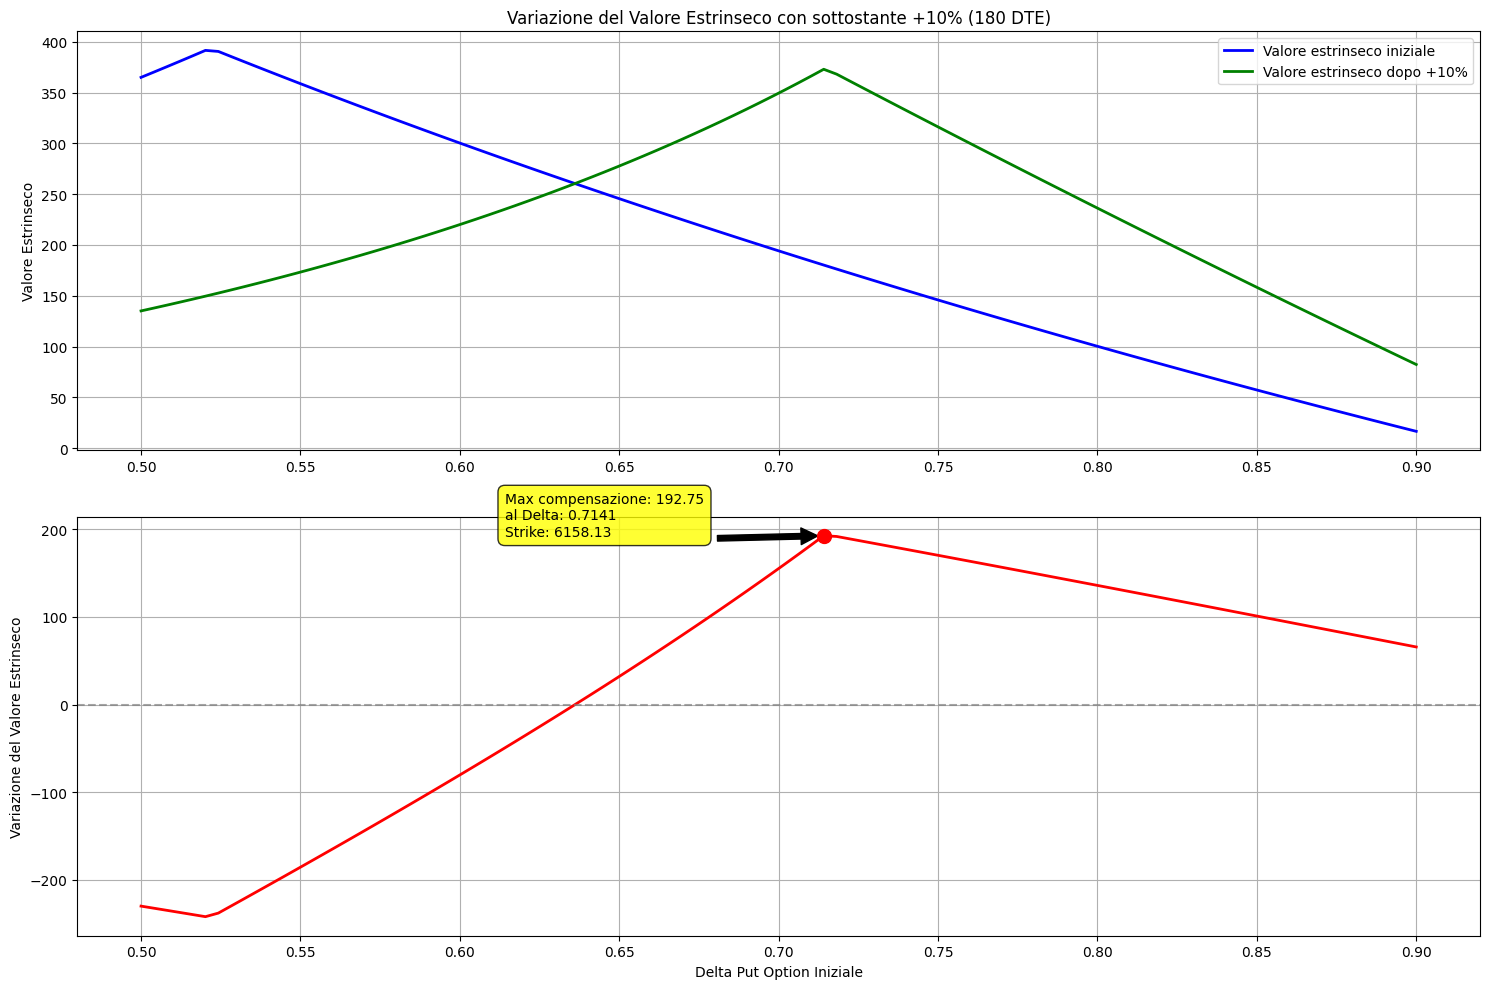

In [19]:
# Analizziamo come cambia il valore estrinseco quando il sottostante sale del 10%
plt.figure(figsize=(12, 8))

# Stesso range di delta dell'analisi precedente
detailed_delta_values = np.linspace(0.5, 0.9, 100)

# Utilizziamo lo stesso riferimento temporale di 180 giorni
ref_dte = 180
closest_idx = np.abs(days_to_maturity - ref_dte).argmin()
t_value = T_values[closest_idx]
price_change_pct = 10

# Vettori per i risultati
strike_prices = []
initial_extrinsic = []
new_extrinsic = []
extrinsic_changes = []

# Per ogni delta, calcola il cambiamento nel valore estrinseco
for delta_val in detailed_delta_values:
    # Strike per questo delta con volatilità originale
    strike = strike_from_delta(S, t_value, r, sigma, 1 - delta_val)
    
    # Prezzo iniziale dell'opzione e valore intrinseco
    initial_put_price = black_scholes_put(S, strike, t_value, r, sigma)
    initial_intrinsic = max(0, strike - S)
    initial_ext = initial_put_price - initial_intrinsic
    
    # Nuovo prezzo e volatilità dopo il movimento del 10%
    new_price = S * (1 + price_change_pct/100)
    new_vol = adjusted_volatility(price_change_pct)
    
    # Nuovo prezzo dell'opzione e valore intrinseco
    new_put_price = black_scholes_put(new_price, strike, t_value, r, new_vol)
    new_intrinsic = max(0, strike - new_price)
    new_ext = new_put_price - new_intrinsic
    
    # Salva i risultati
    strike_prices.append(strike)
    initial_extrinsic.append(initial_ext)
    new_extrinsic.append(new_ext)
    extrinsic_changes.append(new_ext - initial_ext)

# Creazione del grafico
plt.figure(figsize=(15, 10))

# Subplot 1: Valore estrinseco prima e dopo
plt.subplot(2, 1, 1)
plt.plot(detailed_delta_values, initial_extrinsic, 'b-', label=f'Valore estrinseco iniziale', linewidth=2)
plt.plot(detailed_delta_values, new_extrinsic, 'g-', label=f'Valore estrinseco dopo +10%', linewidth=2)
plt.grid(True)
plt.legend()
plt.ylabel('Valore Estrinseco')
plt.title(f'Variazione del Valore Estrinseco con sottostante +10% ({ref_dte} DTE)')

# Subplot 2: Variazione del valore estrinseco
plt.subplot(2, 1, 2)
plt.plot(detailed_delta_values, extrinsic_changes, 'r-', linewidth=2)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.grid(True)
plt.xlabel('Delta Put Option Iniziale')
plt.ylabel('Variazione del Valore Estrinseco')

# Trova dove la variazione del valore estrinseco è massima (compensazione massima)
max_extrinsic_idx = np.argmax(extrinsic_changes)
max_compensation = extrinsic_changes[max_extrinsic_idx]
compensation_delta = detailed_delta_values[max_extrinsic_idx]

# Annotazione dei risultati
plt.scatter(compensation_delta, max_compensation, color='red', s=100, zorder=5)
plt.annotate(f'Max compensazione: {max_compensation:.2f}\n'
             f'al Delta: {compensation_delta:.4f}\n'
             f'Strike: {strike_prices[max_extrinsic_idx]:.2f}',
             xy=(compensation_delta, max_compensation),
             xytext=(compensation_delta - 0.1, max_compensation + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             bbox=dict(boxstyle="round,pad=0.5", fc="yellow", alpha=0.8))

plt.tight_layout()
plt.show()

In [20]:
# Stampa riepilogativa
print(f"\nAnalisi della variazione del valore estrinseco:")
print(f"Delta con massima compensazione del valore estrinseco: {compensation_delta:.4f}")
print(f"Incremento massimo del valore estrinseco: {max_compensation:.2f}")
print(f"Strike corrispondente: {strike_prices[max_extrinsic_idx]:.2f}")
print(f"Questo corrisponde a una compensazione del {(max_compensation/min_decrease)*100:.1f}% della diminuzione totale")
print(f"Delta ottimale considerando tutti gli effetti: {optimal_delta:.4f}")


Analisi della variazione del valore estrinseco:
Delta con massima compensazione del valore estrinseco: 0.7141
Incremento massimo del valore estrinseco: 192.75
Strike corrispondente: 6158.13
Questo corrisponde a una compensazione del 83.8% della diminuzione totale
Delta ottimale considerando tutti gli effetti: 0.5000
